Generation 5 - First Candidate: [0.19908384 0.7059808  0.41534089 0.15552689 0.7400437  0.02741998
 0.07581454 0.35659074 0.84933222 0.42225264 0.5806148  0.54589658
 0.40628396 0.85730719 0.33791002 0.76820798 0.95053819 0.77708971
 0.27024893 0.04493935 0.         0.9968615  0.         0.39978029
 0.26398605 0.         0.06306672 0.66243114 0.         0.90494321]
Objective Values: [0.19908384 3.91559718]
Generation 50 - First Candidate: [1.99083843e-01 0.00000000e+00 2.20212428e-01 4.30934045e-02
 3.74792280e-01 1.25111330e-02 0.00000000e+00 1.48168543e-01
 1.14817733e-01 0.00000000e+00 8.97964221e-01 0.00000000e+00
 2.77465236e-01 1.53470360e-03 0.00000000e+00 1.48703713e-01
 8.34483371e-02 1.10032873e-01 9.42932652e-03 0.00000000e+00
 9.15464194e-01 1.33319840e-01 7.34951975e-01 4.09958174e-04
 9.03485953e-02 0.00000000e+00 0.00000000e+00 5.82453454e-02
 0.00000000e+00 9.85818527e-03]
Objective Values: [0.19908384 1.67522921]
Generation 250 - First Candidate: [0.19908384 0.02021574

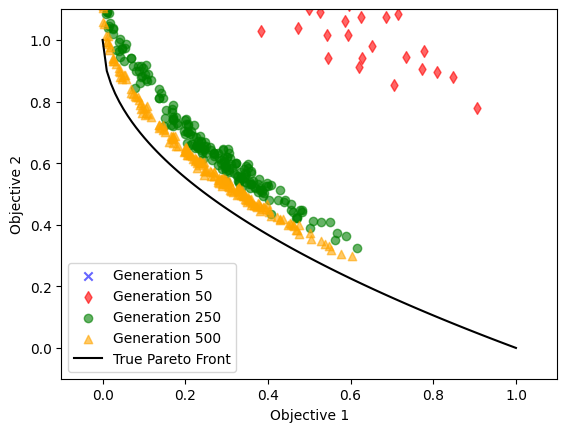

In [42]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate, dimension, bounds, objectives):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = dimension  # Number of parameters
        self.bounds = bounds  # Parameter bounds
        self.objectives = objectives  # List of objective functions

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[obj(x) for obj in self.objectives] for x in candidates])

    # Perform "current-to-best/1/bin" mutation to create mutant vectors
    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            # Save objective values at specific generations for analysis
            if generation in [5, 50, 250, 500]:
                print(f"Generation {generation} - First Candidate: {candidates[0]}")  # Debugging output
                print(f"Objective Values: {candidate_values[0]}")  # Debugging output
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_plot(self):
        generations_to_plot = [5, 50, 250, 500]
        colors = ['blue', 'red', 'green', 'orange']
        markers = ['x', 'd', 'o', '^']

        for generation, candidate_values in self.execute_trial():
            if generation in generations_to_plot:
                label = f'Generation {generation}'
                color = colors[generations_to_plot.index(generation)]
                marker = markers[generations_to_plot.index(generation)]
                self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.savefig("pareto_front.png", bbox_inches='tight')
        plt.show()

# Define the bounds for the problem
bounds = [0, 1]  # Generic bounds for each parameter

# Define the objective functions
def objective1(x):
    return x[0]

def objective2(x):
    g = 1 + (9 / 29) * np.sum(x[1:])
    h = 1 - np.sqrt(x[0] / g)
    return g * h

# Create an instance of the MultiObjectiveDE class and run the trial
de_instance = MultiObjectiveDE(
    population_size=200, 
    num_generations=500, 
    mutation_factor=0.8, 
    crossover_rate=0.9, 
    dimension=30, 
    bounds=bounds, 
    objectives=[objective1, objective2]
)
de_instance.run_and_plot()
